In [19]:
from dataclasses import dataclass
from matplotlib import pyplot as plt

#seaborn : statistical data visualization

import seaborn as sns
import pandas as pd
import numpy as np
from numpy import dtype
from sklearn import metrics, model_selection, preprocessing

import torch
import torch.nn as nn
import torch.utils.data

In [11]:
@dataclass
class Config:
    DATASET = "./dataset_phishing.csv"
    TARGET_COL = "status"
    DEVICE = "cpu"
    EPOCHS = 10
    TRAIN_BS = 1024
    VALID_BS = 1024
    LR = 3e-3

In [12]:
print(Config.DATASET)

./dataset_phishing.csv


In [13]:
class Dataset:
    def __init__(self, data, target) -> None:
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        return dict(
            data=torch.tensor(self.data[item], dtype=torch.float),
            target=torch.tensor(self.target[item], dtype=torch.float),
        )

In [14]:
class Model(nn.Module):
    def __init__(self, n_inputs, hidden_units_1, hidden_units_2, n_outputs) -> None:
        super().__init__()
        self.pipeline1 = nn.Sequential(
            nn.Linear(n_inputs, hidden_units_1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_units_1),
            nn.Linear(hidden_units_1, hidden_units_1),
            nn.BatchNorm1d(hidden_units_1),
            nn.Dropout(0.20),
        )
        self.pipeline2 = nn.Sequential(
            nn.Linear(hidden_units_1, hidden_units_2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_units_2),
            nn.Linear(hidden_units_2, hidden_units_2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_units_2),
            nn.Dropout(0.20),
            nn.Linear(hidden_units_2, hidden_units_1),
        )
        self.output_pipeline = nn.Sequential(nn.Linear(hidden_units_1, n_outputs))

    def forward(self, data):
        out = self.pipeline1(data)
        out = self.pipeline2(out)
        out = self.output_pipeline(out)
        return out

In [15]:
class Engine:
    @staticmethod
    def train(epoch, model, dataset, criterion, optimizer, scheduler):
        model.to(Config.DEVICE)
        model.train()
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=Config.TRAIN_BS)
        losses = 0
        for batch_idx, tdata in enumerate(dataloader):
            data = tdata["data"].to(Config.DEVICE)
            target = tdata["target"].to(Config.DEVICE)
            output = model(data)
            optimizer.zero_grad()
            loss = criterion(output, target.view(-1, 1))
            com_metric = Engine.compute_metrics(output, target.view(-1, 1))
            losses += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()

            print(
                "[train]: epoch:{0} batch:[{1}/{2}] loss:{3} metrics:{4} ".format(
                    epoch,
                    batch_idx,
                    len(dataloader),
                    (losses / len(dataloader)),
                    com_metric,
                )
            )

    @staticmethod
    def eval(epoch, model, dataset):
        print("---------- * --------------\n")
        model.to(Config.DEVICE)
        model.eval()
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=Config.VALID_BS)
        with torch.no_grad():
            for batch_idx, tdata in enumerate(dataloader):
                data = tdata["data"].to(Config.DEVICE)
                target = tdata["target"].to(Config.DEVICE)
                output = model(data)
                com_metric = Engine.compute_metrics(output, target.view(-1, 1))

                print(
                    "[valid]: epoch:{0} batch:[{1}/{2}] metrics:{3} ".format(
                        epoch,
                        batch_idx,
                        len(dataloader),
                        com_metric,
                    )
                )
            print("---------- * --------------\n")

    @staticmethod
    def generate_predictions(model, dataset, batch_size=1024):
        predictions = []
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
        with torch.no_grad():
            model.eval()
            for batch_idx, tdata in enumerate(dataloader):
                data = tdata["data"].to(Config.DEVICE)
                target = tdata["target"].to(Config.DEVICE)
                output = torch.sigmoid(model(data)).detach().cpu().numpy() >= 0.5
                predictions.extend(output)

        return predictions

    @staticmethod
    def compute_metrics(output, target=None):
        if target is None:
            return {}

        device = target.device.type
        output = torch.sigmoid(output).detach().cpu().numpy() >= 0.5
        target = target.detach().cpu().numpy()

        accuracy = metrics.accuracy_score(target, output)
        f1_score = metrics.f1_score(target, output)
        return dict(
            accuracy=torch.tensor(accuracy, device=device, dtype=torch.float32),
            f1_score=torch.tensor(f1_score, device=device, dtype=torch.float32),
        )

cat_cols: ['url', 'status']
                                                    url      status  target
7009              http://www.chamber-international.com/  legitimate       0
2201    http://user7770001255.el.r.appspot.com/ver.html    phishing       1
3074                 https://react-ba2roi.stackblitz.io    phishing       1
7481  https://support-appleld.com.secureupdate.duila...    phishing       1
561   http://www.shadetreetechnology.com/V4/validati...    phishing       1
{'xtrain_shape': (9144, 87), 'xtest_shape': (2286, 87)}
Model(
  (pipeline1): Sequential(
    (0): Linear(in_features=87, out_features=300, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=300, out_features=300, bias=True)
    (4): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.2, inplace=False)
  )
  (pipeline2): Sequential(
    (0): Linear(in_features=300, out_

[train]: epoch:5 batch:[3/9] loss:0.028022228015793696 metrics:{'accuracy': tensor(0.9727), 'f1_score': tensor(0.9723)} 
[train]: epoch:5 batch:[4/9] loss:0.036234031120936074 metrics:{'accuracy': tensor(0.9756), 'f1_score': tensor(0.9768)} 
[train]: epoch:5 batch:[5/9] loss:0.04301029857661989 metrics:{'accuracy': tensor(0.9766), 'f1_score': tensor(0.9751)} 
[train]: epoch:5 batch:[6/9] loss:0.049609562589062586 metrics:{'accuracy': tensor(0.9785), 'f1_score': tensor(0.9784)} 
[train]: epoch:5 batch:[7/9] loss:0.05688711255788803 metrics:{'accuracy': tensor(0.9746), 'f1_score': tensor(0.9746)} 
[train]: epoch:5 batch:[8/9] loss:0.06310547846886846 metrics:{'accuracy': tensor(0.9842), 'f1_score': tensor(0.9840)} 
---------- * --------------

[valid]: epoch:5 batch:[0/3] metrics:{'accuracy': tensor(0.9561), 'f1_score': tensor(0.9551)} 
[valid]: epoch:5 batch:[1/3] metrics:{'accuracy': tensor(0.9434), 'f1_score': tensor(0.9431)} 
[valid]: epoch:5 batch:[2/3] metrics:{'accuracy': tensor(0

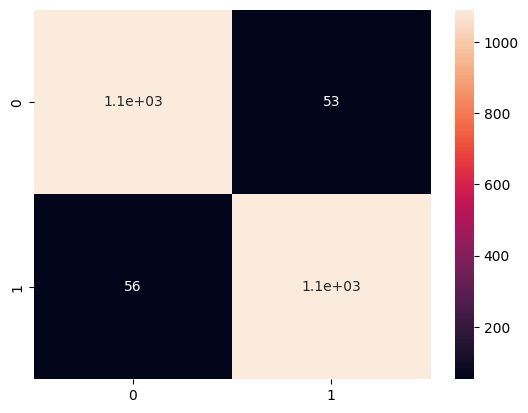

In [16]:
if __name__ == "__main__":
    dfx = pd.read_csv(Config.DATASET)
    cat_cols = [col for col in dfx.columns if dfx[col].dtype == "object"]
    print("cat_cols:", cat_cols)
    dfx["target"] = preprocessing.LabelEncoder().fit_transform(dfx[Config.TARGET_COL])
    print(dfx[[*cat_cols, "target"]].sample(5))
    df = dfx.drop(["url", "status"], axis=1)

    # corr = df.corr()
    # plt.imshow(corr, cmap="viridis", interpolation="nearest")
    # plt.colorbar()
    # plt.show()

    data = preprocessing.MinMaxScaler().fit_transform(
        df.drop(["target"], axis=1).values
    )
    targets = df["target"].values

    xtrain, xtest, ytrain, ytest = model_selection.train_test_split(
        data, targets, test_size=0.20, random_state=0, stratify=df["target"]
    )
    print(
        dict(
            xtrain_shape=xtrain.shape,
            xtest_shape=xtest.shape,
        )
    )

    train_dataset = Dataset(xtrain, ytrain)
    valid_dataset = Dataset(xtest, ytest)

    model = Model(
        n_inputs=data.shape[1], hidden_units_1=300, hidden_units_2=100, n_outputs=1
    )
    print(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=Config.LR)
    schduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=0.78, gamma=0.3)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(Config.EPOCHS):
        Engine.train(
            epoch=epoch,
            model=model,
            dataset=train_dataset,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=schduler,
        )
        Engine.eval(epoch=epoch, model=model, dataset=valid_dataset)
        torch.save(model, "model.bin")

    predictions = Engine.generate_predictions(model=model, dataset=valid_dataset)
    confus_mat = metrics.confusion_matrix(ytest, predictions)
    sns.heatmap(confus_mat, annot=True)
    plt.show()

In [32]:
# weight = np.fromfile("model.bin")
test_model = Model(
    n_inputs=data.shape[1], hidden_units_1=300, hidden_units_2=100, n_outputs=1
)
temp_modal = torch.load("model.bin")

for name,param in model.named_parameters():
    print(name, param.shape)
test_model.load_state_dict(torch.load("model.bin", map_location='cpu'))

pipeline1.0.weight torch.Size([300, 87])
pipeline1.0.bias torch.Size([300])
pipeline1.2.weight torch.Size([300])
pipeline1.2.bias torch.Size([300])
pipeline1.3.weight torch.Size([300, 300])
pipeline1.3.bias torch.Size([300])
pipeline1.4.weight torch.Size([300])
pipeline1.4.bias torch.Size([300])
pipeline2.0.weight torch.Size([100, 300])
pipeline2.0.bias torch.Size([100])
pipeline2.2.weight torch.Size([100])
pipeline2.2.bias torch.Size([100])
pipeline2.3.weight torch.Size([100, 100])
pipeline2.3.bias torch.Size([100])
pipeline2.5.weight torch.Size([100])
pipeline2.5.bias torch.Size([100])
pipeline2.7.weight torch.Size([300, 100])
pipeline2.7.bias torch.Size([300])
output_pipeline.0.weight torch.Size([1, 300])
output_pipeline.0.bias torch.Size([1])


TypeError: Expected state_dict to be dict-like, got <class '__main__.Model'>.

In [21]:
print(weight)

[ 5.67865055e-270  0.00000000e+000  0.00000000e+000 ...  2.31584179e+077
  6.40666591e-145 -5.53294723e-222]


In [36]:
import content_features as ctnfe
import url_features as urlfe
import external_features as trdfe
import ml_models as models
import pandas as pd 
import urllib.parse
import tldextract
import requests
import json
import csv
import os
import re


from pandas2arff import pandas2arff
from urllib.parse import urlparse
from bs4 import BeautifulSoup

ModuleNotFoundError: No module named 'Levenshtein'